# CFF Fitting using Gepard

## Dataset

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import gepard as g
print(g.__file__)
#import sys

/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/__init__.py


In [4]:
# Temp 
import numpy as np 
#np.set_printoptions(legacy='1.25')
import pandas as pd 
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt

In [173]:
import gepard as g
from gepard import model, fitter, data, plots
import gepard.plots as gplot
from gepard.fits import GLO15new, AUTIpts, ALUIpts, th_KM15, th_KM10b
import matplotlib.pyplot as plt
from gepard.fits import th_KM15
th15 = th_KM15
import torch
import shelve, logging, sys, copy
logging.basicConfig(level=logging.ERROR) # Temp
#from gepard.fits import th_KM12
#th12 = th_KM15
from gepard.constants import Mp2, toTeX

In [20]:
#GEPARD_DIR = os.path.dirname(g.__file__)
#db = shelve.open(GEPARD_DIR+'/theories.db') 

In [25]:
'''with shelve.open(GEPARD_DIR+'/theories.db', flag='r') as db:
    # Example: Retrieve a value by key
    #value = db.get('your_key', 'default_value')
    #print(value)

    # Example: List all keys
    keys = list(db.keys())
    print(keys)

    # Example: Modify or add a value
    #db['new_key'] = 'new_value'

    # Example: Delete a key
    #if 'old_key' in db:
        #del db['old_key'] '''

[]


In [6]:
# We want nice LaTeX fonts on plots
plt.rc('text', usetex=True)
params = {'text.latex.preamble' : '\n'.join([r'\usepackage{amssymb}', r'\usepackage{amsmath}'])}
plt.rcParams.update(params)

In [7]:
#utils.listdata([101,102], data)
fitpoints = g.dset[101] + g.dset[102] #+ g.dset[8] + g.dset[97] + g.dset[7] + g.dset[99] #+
g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 144


In [8]:
#utils.listdata([8], data)
data = g.dset[7] #[8]
BSA = data.df()   # ALU(90 deg) by CLAS 2007
data = g.dset[102]
BSS = data.df()  # CLAS 2015
data = g.dset[101]
BSD = data.df()  # CLAS 2015

In [9]:
data = g.dset[97]  # unrestricted CLAS 2015, phi-dep
BSDphi = data.df() 

In [10]:
tmlims = [0, 0.13, 0.18, 0.22, 0.3, 0.4, 0.5]
xilims = [0, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.26]

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

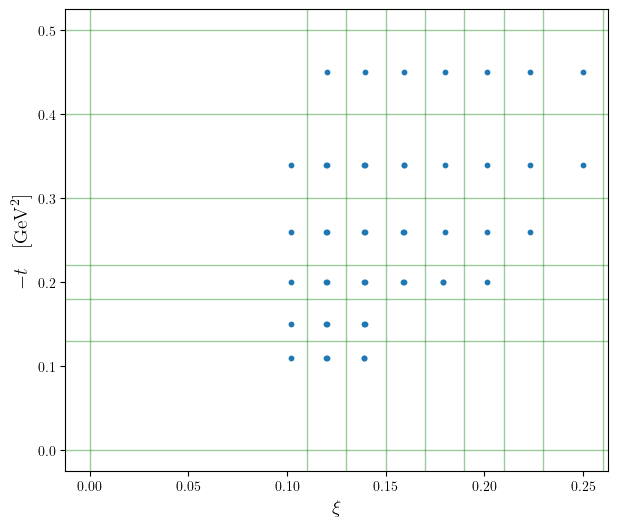

In [11]:
#plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSD.xi, BSD.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
#fig.savefig('bins.pdf')

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

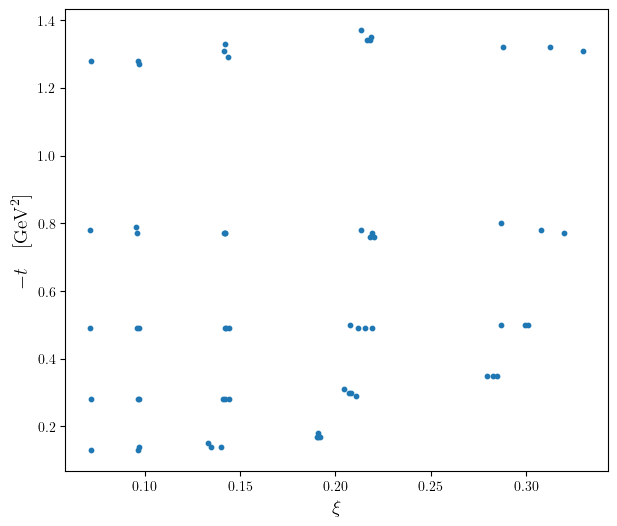

In [12]:
fig, ax = plt.subplots(figsize=[7,6])
plt.scatter(BSA.xi, BSA.tm, s=10)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

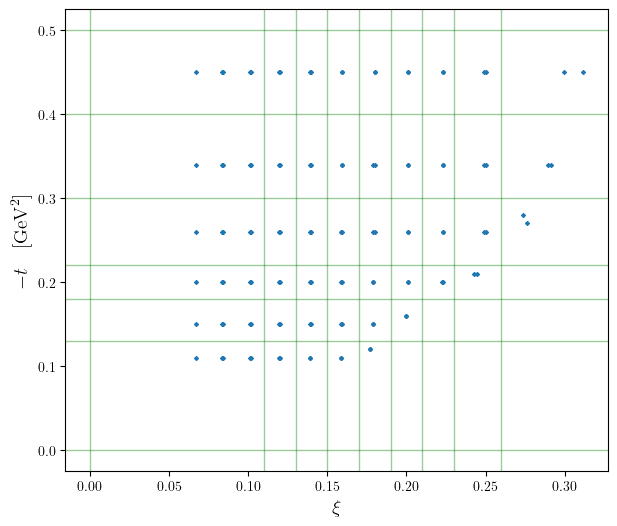

In [13]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSDphi.xi, BSDphi.tm, s=2)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

## Fit with NN

In [26]:
class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BMK):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = torch.nn.Sequential(
                torch.nn.Linear(2, 12),
                torch.nn.ReLU(),
                torch.nn.Linear(12, 17),
                torch.nn.ReLU(),
                torch.nn.Linear(17, 12),
                torch.nn.ReLU(),
                torch.nn.Linear(12, len(self.output_layer))
            )
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer

In [27]:
g.describe_data(fitpoints)
th = NNTest(output_layer=['ImH', 'ReH'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#
print(th.useDR)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 144
None


In [28]:
f = g.fitter.NeuralFitter(fitpoints, th, nnets=10, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
f.fitgood()

/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch  10: train error = 1.6066 test error = 1.5846 -
Epoch  20: train error = 1.2065 test error = 1.2469 -
Epoch  30: train error = 1.1089 test error = 1.3859 +
Epoch  40: train error = 1.0380 test error = 1.4792 +
Epoch  50: train error = 0.9903 test error = 1.5704 +
Epoch  60: train error = 0.9428 test error = 1.5182 +test_err = 1.246907199976624 < max_test_err = 2 so we accept the net
[Try 1/100] 1 good nets. Last test_err = 1.246907199976624

Epoch  10: train error = 1.1358 test error = 1.5773 -
Epoch  20: train error = 0.9202 test error = 1.5028 -
Epoch  30: train error = 0.8281 test error = 1.5068 +
Epoch  40: train error = 0.7656 test error = 1.7252 +
Epoch  50: train error = 0.7030 test error = 1.8956 +
Epoch  60: train error = 0.6629 test error = 1.8446 +test_err = 1.502802322433282 < max_test_err = 2 so we accept the net
[Try 2/100] 2 good nets. Last test_err = 1.502802322433282

Epoch  10: train error = 1.3885 test error = 0.9238 -
Epoch  20: train error = 1.2665 test erro

### Use shelve to store the trained models

In [29]:
# create a shelf file 
shelve_file = shelve.open("Models") 

# Store num list in shelf file 
shelve_file['NoDR'] = th.nets
  
# now, we simply close the shelf file. 
shelve_file.close()

In [30]:
shelve_file = shelve.open("Models") 
  
NoDR=shelve_file['NoDR']

th4 = NNTest(output_layer=['ImH', 'ReH'])
th4.nets = NoDR

# print keys list 
#print(f"Keys = {list(shelve_file.keys())}") 
  
# now, we simply close the shelf file. 
shelve_file.close() 

### Various tests

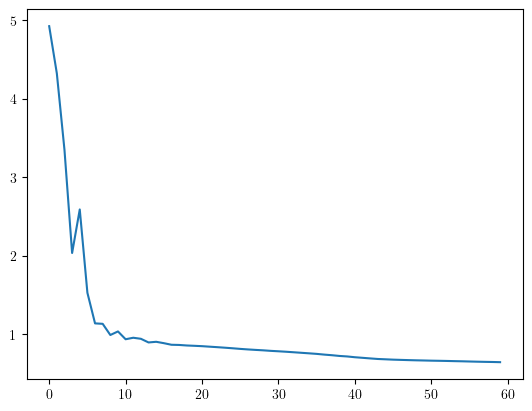

Fit on CLAS data


In [31]:
plt.figure()
plt.plot(f.history)
plt.show()
th.name = "Fit on CLAS data"
print(th.name)

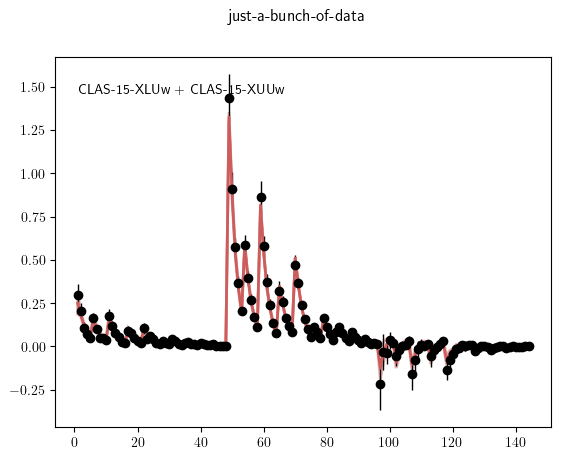

In [32]:
fig = gplot.jbod(points=fitpoints, lines=[th], bands=[th])

In [33]:
#%%time
th.chisq(g.dset[101]+g.dset[102])

(np.float64(40.87520605461981), 144, np.float64(1.0))

### CFFs plots in the no DR case

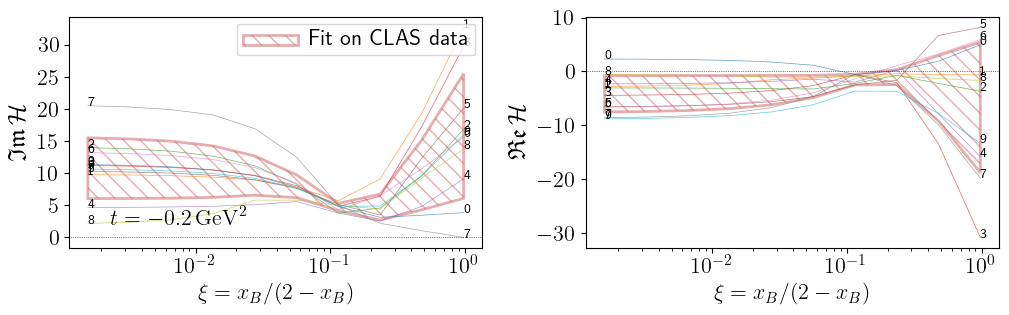

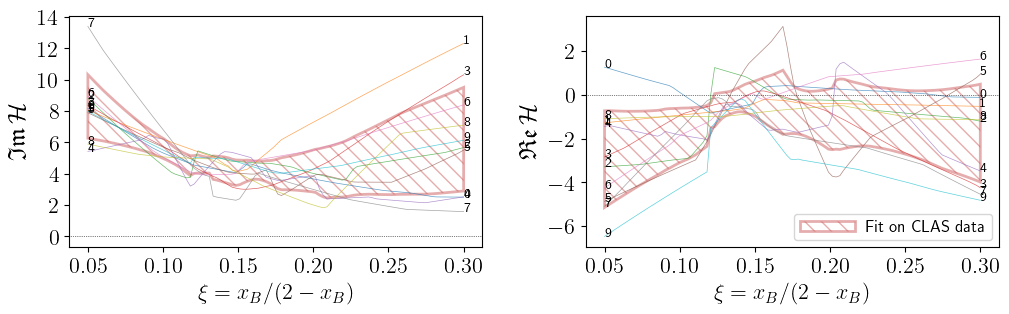

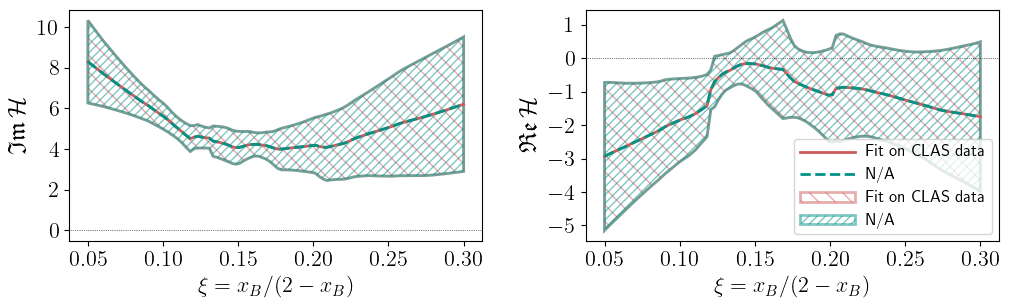

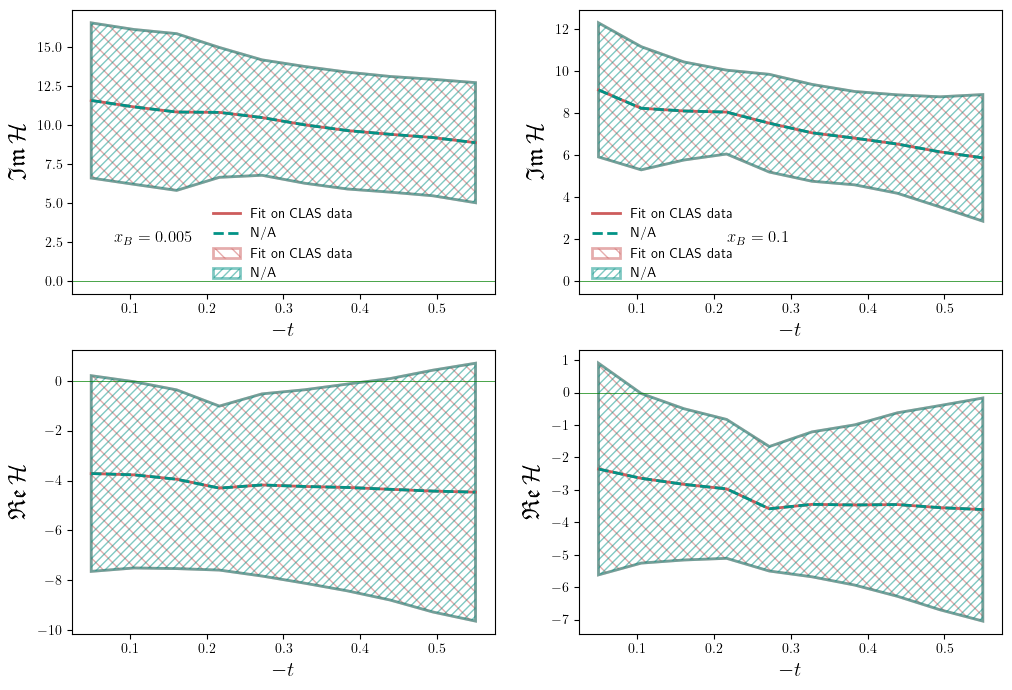

In [34]:
#fig = gplot.CFF3(cffs=['ImH', 'ReH'],  bands=[th], tval=-0.2)
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th, bands=[th], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th, bands=[th])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th4], bands=[th, th4])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th4], bands=[th, th4])
#fig.savefig('NN-mesh.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

## Custom NN

In [35]:
import torch.nn as nn
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 7)  # 2 input features, 7 hidden units
        self.n2 = nn.Linear(7, 7)  # 7 hidden units, 7 hidden units
        self.n3 = nn.Linear(7, 1)  # 7 hidden units, 2 output features
        
        self.n1p = nn.Linear(1, 7)  # 2 input features, 7 hidden units
        self.n2p = nn.Linear(7, 7)  # 7 hidden units, 7 hidden units
        self.n3p = nn.Linear(7, 1)  # 7 hidden units, 2 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

### Create the class inheriting from DispersionCFF

In [36]:
class NNTest_DR(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BMK, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(1, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.zero(pt)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [37]:
th2 = NNTest_DR(output_layer=['ImH', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

In [38]:
g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 144


In [39]:
fitpoints_1 =  g.dset[8] + g.dset[101] + g.dset[102] # + g.dset[97] + g.dset[99] +
g.describe_data(fitpoints_1)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 156


In [40]:
f = g.fitter.NeuralFitter(fitpoints_1, th2, nnets=5, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
f.fitgood()
#torch.save(th.nets, 'Test_dataset7_nets.tar')

/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:399: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch  10: train error = 2.0152 test error = 1.6414 -
Epoch  20: train error = 1.3266 test error = 1.7278 +
Epoch  30: train error = 1.2771 test error = 1.7160 +
Epoch  40: train error = 1.2604 test error = 1.7478 +
Epoch  50: train error = 1.2524 test error = 1.7647 +
Epoch  60: train error = 1.2452 test error = 1.8128 +
No improvement for 5 batches. Stopping early.
test_err = 1.6413824477320536 < max_test_err = 2 so we accept the net
[Try 1/100] 1 good nets. Last test_err = 1.6413824477320536

Epoch  10: train error = 2.6237 test error = 2.3417 -
Epoch  20: train error = 1.2947 test error = 1.9391 -
Epoch  30: train error = 1.1160 test error = 1.8259 -
Epoch  40: train error = 1.0351 test error = 2.0323 +
Epoch  50: train error = 0.9960 test error = 2.2541 +
Epoch  60: train error = 0.9903 test error = 2.3427 +test_err = 1.8258770363064711 < max_test_err = 2 so we accept the net
[Try 2/100] 2 good nets. Last test_err = 1.8258770363064711

Epoch  10: train error = 1.5098 test error =

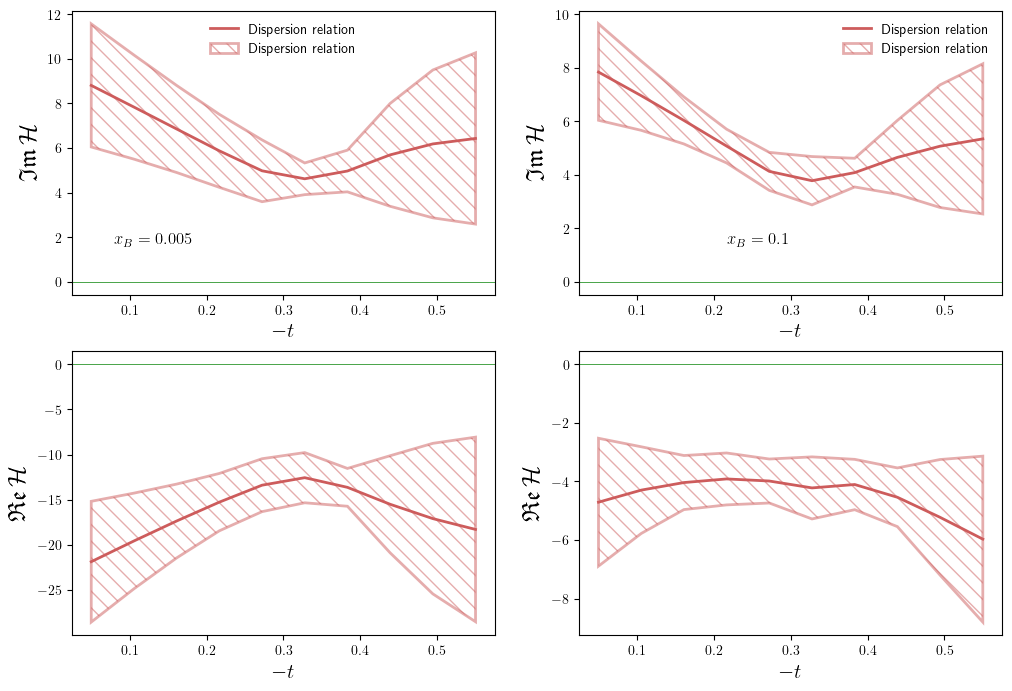

In [41]:
th2.name = "Dispersion relation"
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=th2, bands=[th2])

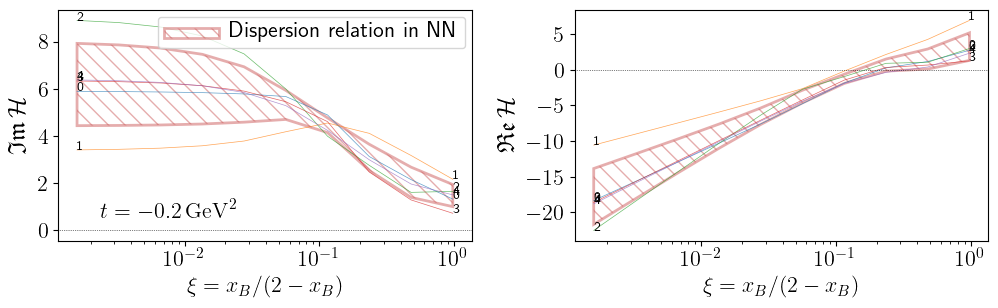

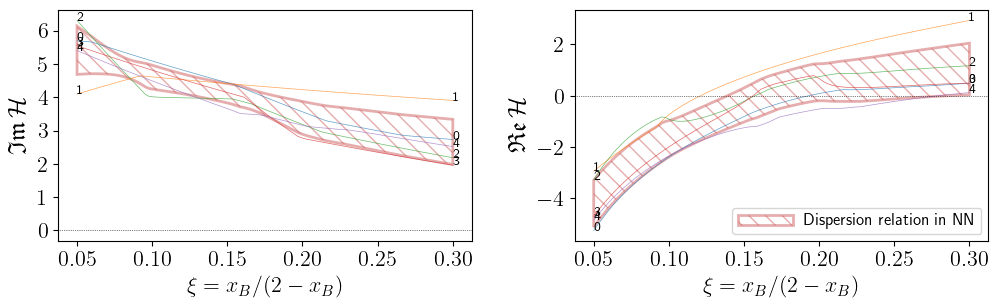

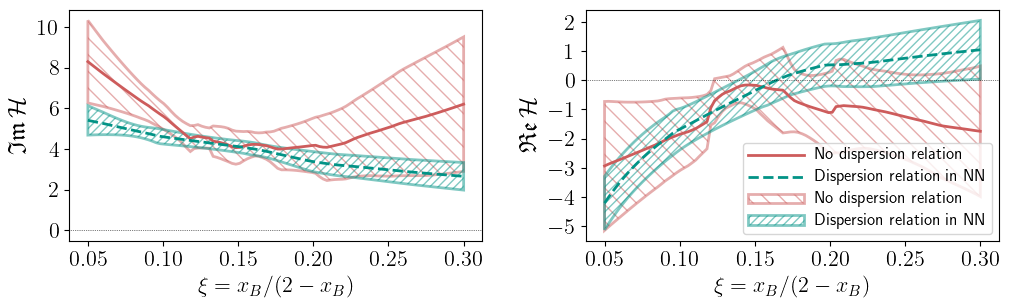

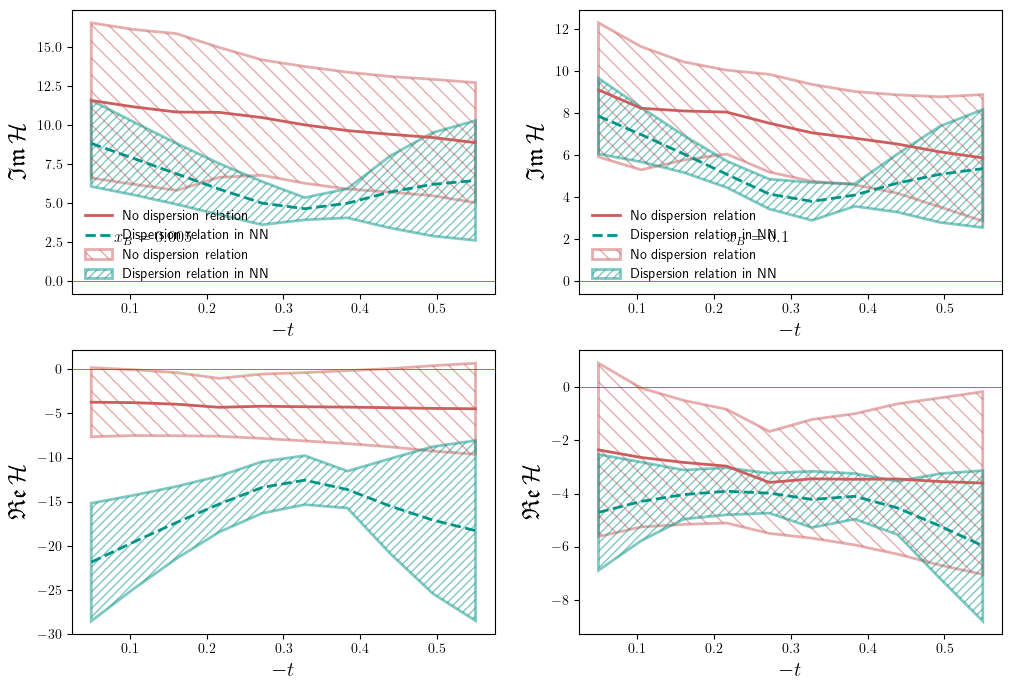

In [42]:
th.name = "No dispersion relation"
th2.name = "Dispersion relation in NN"
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])

## Test with 4 CFFs

In [44]:
class CustomNetwork_4(nn.Module):
    def __init__(self):
        super(CustomNetwork_4, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 7)  # 2 input features, 7 hidden units
        self.n2 = nn.Linear(7, 7)  # 7 hidden units, 7 hidden units
        self.n3 = nn.Linear(7, 2)  # 7 hidden units, 2 output features
        
        self.n1p = nn.Linear(1, 7)  # 2 input features, 7 hidden units
        self.n2p = nn.Linear(7, 7)  # 7 hidden units, 7 hidden units
        self.n3p = nn.Linear(7, 1)  # 7 hidden units, 2 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

In [45]:
class NNTest_DR_4(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BMK, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork_4()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #print("I am here in D")
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(2, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.cffs(1, pt, xi)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [46]:
th3 = NNTest_DR_4(output_layer=['ImH', 'ImE', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

In [47]:
f = g.fitter.NeuralFitter(fitpoints_1, th3, nnets=5, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
f.fitgood()

/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:399: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch  10: train error = 1.6767 test error = 1.5315 -
Epoch  20: train error = 1.2691 test error = 1.7561 +
Epoch  30: train error = 1.1691 test error = 1.7092 +
Epoch  40: train error = 1.0972 test error = 1.7536 +
Epoch  50: train error = 1.0510 test error = 1.7916 +
Epoch  60: train error = 1.0218 test error = 1.8441 +
No improvement for 5 batches. Stopping early.
test_err = 1.5315435439287681 < max_test_err = 2 so we accept the net
[Try 1/100] 1 good nets. Last test_err = 1.5315435439287681

Epoch  10: train error = 2.1163 test error = 2.3877 -
Epoch  20: train error = 1.1387 test error = 1.7769 -
Epoch  30: train error = 1.0647 test error = 1.8096 +
Epoch  40: train error = 1.0445 test error = 1.8082 +
Epoch  50: train error = 1.0180 test error = 1.7932 +
Epoch  60: train error = 0.9932 test error = 1.7818 +test_err = 1.776918315556884 < max_test_err = 2 so we accept the net
[Try 2/100] 2 good nets. Last test_err = 1.776918315556884

Epoch  10: train error = 2.0668 test error = 3

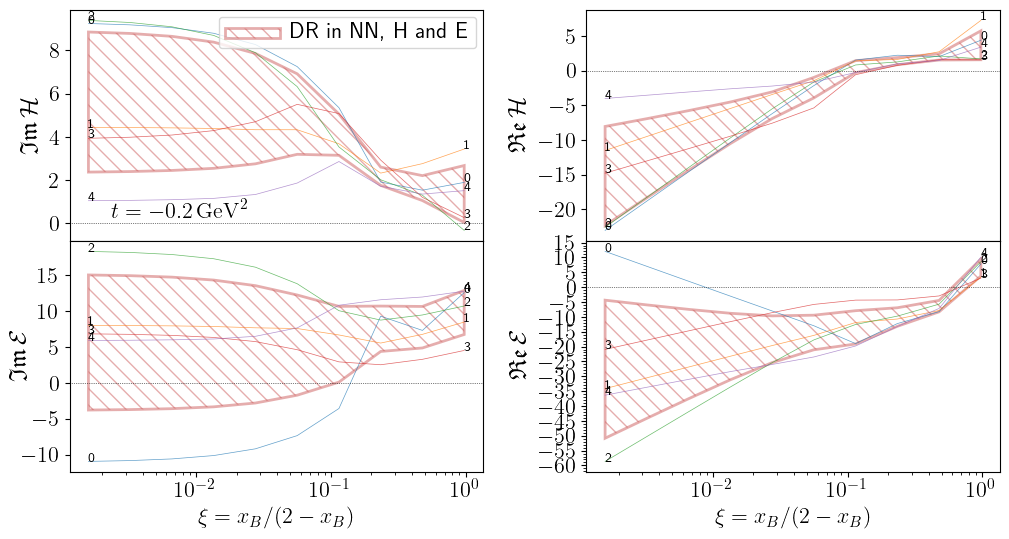

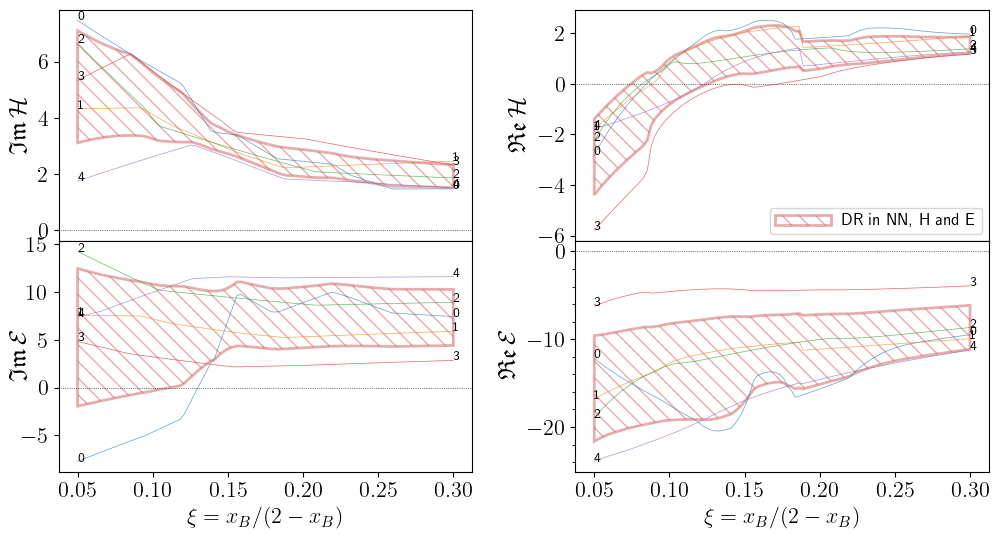

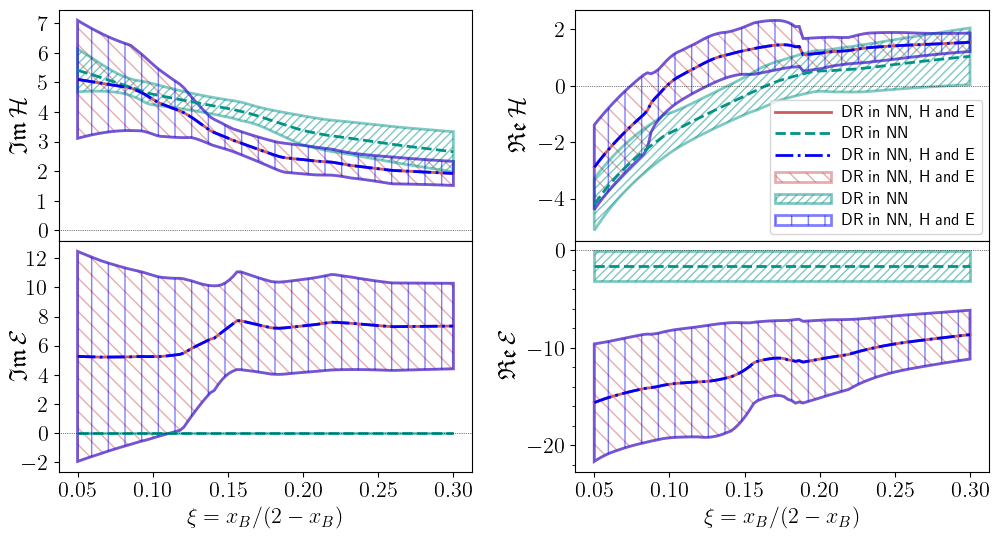

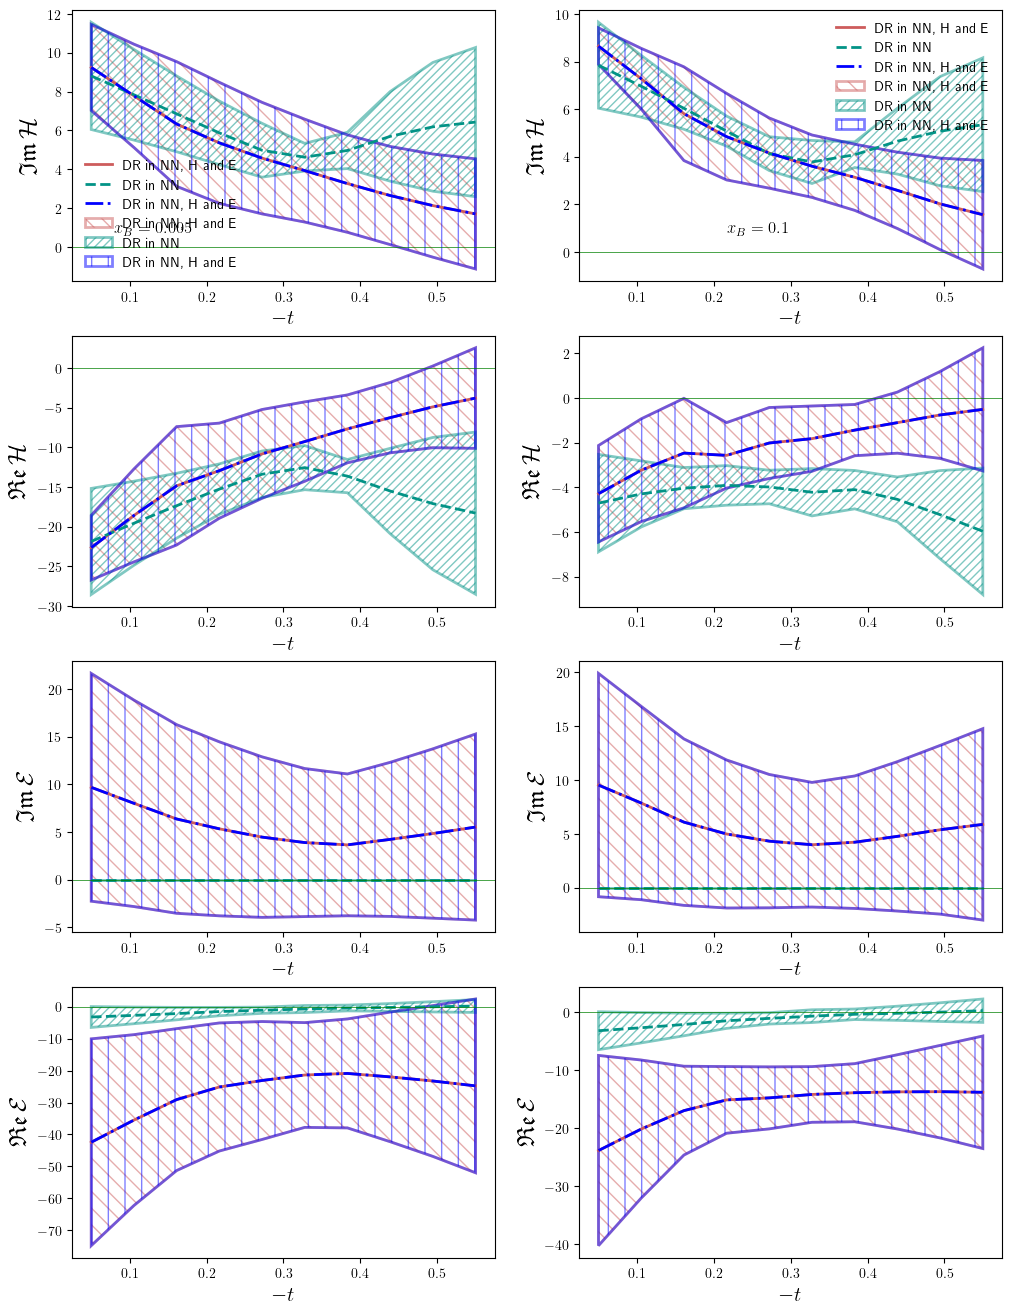

In [143]:
th.name = "No DR"
th2.name = "DR in NN"
th3.name = "DR in NN, H and E"
fig = gplot.CFF3log(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3])
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2, th3], bands=[th, th2, th3])
fig = gplot.CFFt(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2, th3], bands=[th, th2, th3])

## D-term using NN

In [125]:
'''ptts = []
for tm in [0.1, 0.2, 0.3, 0.4]:
    ptb = data[8].copy()  # take some random point and set/change -t
    ptb.t = -tm
    ptb.tm = tm
    ptb.prepare()
    th15.prepare(ptb)
    ptts.append(ptb)
'''

[DataPoint: XLU = 0.2531, DataPoint: XLU = 0.2531, DataPoint: XLU = 0.2531, DataPoint: XLU = 0.2531]


In [126]:
'''D = []
#print(th2.m.__dict__)
#print(getattr(th2, 'nn_model'))
for pt in ptts[::-1]:
    #print(-th2.m.subtraction(pt).detach().numpy()*18./25.)
    Ds = []
    for k in range(len(th2.m.nets)):
        th2.m.parameters['nnet'] = k
        # NOTE: subtraction in code is equal to -\Delta(t) !
        Ds.append(-th2.m.subtraction(pt).detach().numpy()*18./25.) 
        #print(-th2.m.ImH(pt).detach().numpy()*18./25.)
    Ds = np.array(Ds)
    print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
    D.append((pt.tm, Ds.mean(), Ds.std())) '''

0.126, -0.4: 0.6824942827224731 +- 0.0
0.126, -0.3: 0.23157361149787903 +- 1.4901161193847656e-08
0.126, -0.2: 0.09843982756137848 +- 0.0
0.126, -0.1: 0.09576910734176636 +- 0.0


In [ ]:
''' D_array = np.array(D[1], dtype=[('tm', float), ('mean', float), ('std', float)])
print(D_array.mean)
print(D_array.std)
scaled_mean = D_array['mean'] * (25./18.)
print(scaled_mean) '''

In [99]:
ptts = []

for tm in [0.1, 0.2, 0.3, 0.4]:
    ptb = g.dset[102][5].copy()  # take some random point and set/change -t
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)
print(ptts)

[DataPoint: XUUw = 0.587, DataPoint: XUUw = 0.587, DataPoint: XUUw = 0.587, DataPoint: XUUw = 0.587]


In [103]:
import random
ptts = []
tm_list = [0.1, 0.2, 0.3, 0.4]

for tm in tm_list:
    rndm_idx = random.randint(0, len(tm_list)-1)
    ptb = g.dset[102][rndm_idx].copy()  # take some random point and set/change -t
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)
print(ptts)

[DataPoint: XUUw = 0.364, DataPoint: XUUw = 0.911, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437]


In [104]:
th2.name = "DR in NN whit 2 CFFs"
th3.name = "DR in NN with 4 CFFs"

In [120]:
print(th2.m.__dict__)
#print(getattr(th2, 'nn_model'))

{'nets': [(CustomNetwork(
  (n1): Linear(in_features=2, out_features=7, bias=True)
  (n2): Linear(in_features=7, out_features=7, bias=True)
  (n3): Linear(in_features=7, out_features=1, bias=True)
  (n1p): Linear(in_features=1, out_features=7, bias=True)
  (n2p): Linear(in_features=7, out_features=7, bias=True)
  (n3p): Linear(in_features=7, out_features=1, bias=True)
), tensor([[ 0.2599, -0.2520]]), tensor([[0.0594, 0.1014]])), (CustomNetwork(
  (n1): Linear(in_features=2, out_features=7, bias=True)
  (n2): Linear(in_features=7, out_features=7, bias=True)
  (n3): Linear(in_features=7, out_features=1, bias=True)
  (n1p): Linear(in_features=1, out_features=7, bias=True)
  (n2p): Linear(in_features=7, out_features=7, bias=True)
  (n3p): Linear(in_features=7, out_features=1, bias=True)
), tensor([[ 0.2611, -0.2631]]), tensor([[0.0555, 0.1042]])), (CustomNetwork(
  (n1): Linear(in_features=2, out_features=7, bias=True)
  (n2): Linear(in_features=7, out_features=7, bias=True)
  (n3): Linear

In [116]:
D = []
for th in [th2, th3]:
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    A = []
    for pt in ptts[::-1]:
        Ds = []
        for k in range(len(th2.m.nets)):
            th2.m.parameters['nnet'] = k
            # NOTE: subtraction in code is equal to -\Delta(t) !
            Ds.append(-th2.m.subtraction(pt).detach().numpy()*18./25.) 
            #print(-th2.m.ImH(pt).detach().numpy()*18./25.)
        Ds = np.array(Ds)
        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th.m.parameters['nnet'] = 'ALL'    
    D.append(A)


---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.4: 0.4839337468147278 +- 0.0
0.185, -0.3: 0.4839337468147278 +- 0.0
0.185, -0.2: 0.4839337468147278 +- 0.0
0.185, -0.1: 0.4839337468147278 +- 0.0

---- [DR in NN with 4 CFFs - N/A] ----
0.185, -0.4: 0.4839337468147278 +- 0.0
0.185, -0.3: 0.4839337468147278 +- 0.0
0.185, -0.2: 0.4839337468147278 +- 0.0
0.185, -0.1: 0.4839337468147278 +- 0.0


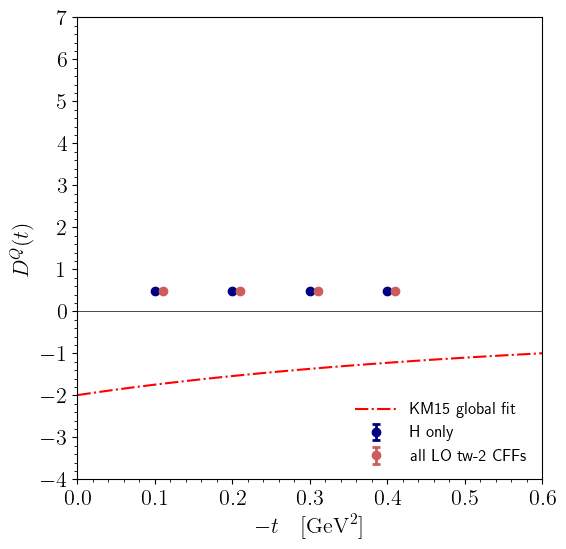

In [107]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H only')
ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
            capsize=3, capthick=2, marker='o', color='indianred', label='all LO tw-2 CFFs')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-4, 7)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 


In [150]:
print(th2.m.subtraction(g.dset[102][5]).detach().numpy()*18./25.)
print(th2.m.subtraction(g.dset[102][6]).detach().numpy()*18./25.)
print(th2.m.subtraction(ptts[1]).detach().numpy()*18./25.)

print(th2.m.ImH(g.dset[102][5]).detach().numpy()*18./25.)
print(th2.m.ImH(g.dset[102][6]).detach().numpy()*18./25.)
print(th2.m.ImH(ptts[1]).detach().numpy()*18./25.)

[-0.48393375]
[-0.48393375]
[-0.48393375]
[3.9879844]
[3.5650299]
[3.2096262]


## Pressure Distribution
### Code for pressure in terms of D-term

In [140]:
def Dterm(t, D0=-1.6, M=0.7, p=3):
    """D-term parametrization"""
    return D0/(1-t/M**2)**p

(-2.0, 0.0)

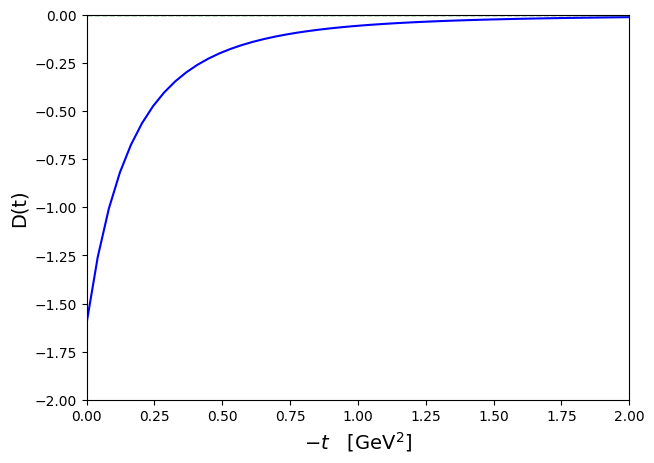

In [141]:
# Plotting this D-term
fig, ax = plt.subplots(1, 1, figsize=[7,5])
tms = np.linspace(0,2)
ax.plot(tms, Dterm(-tms), 'b-')
ax.set_ylabel(r'D(t)', fontsize=14)
ax.set_xlabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-2,0)
# fig.savefig('figs/dterm.pdf')

In [142]:
def pressureNnaive(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    intg = quad(lambda t: np.sin(np.sqrt(-t)*rGeV)*t*Dterm(t, **args), -np.inf, 0, epsabs=0)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

In [143]:
def pressureN(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    # variable change x=-t^2, so QUADPACK Fourier integral method can be used
    intg = quad(lambda x: 2*x*(-x**2)*Dterm(-x**2, **args), 0, np.inf, weight='sin', wvar=rGeV)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

In [144]:
def pressureA(r, D0=-1.6, M=0.7, p=3):
    """Pressure distribution r^2*p(r) in GeV/fm for specific Dterm(t) function
    
     D(t) = D0/(1-t/M^2)^p  with p=2 or 3
    
    """
    GeVfm = 0.197
    Mp = 0.938
    assert p in [2,3]
    rGeV = r/GeVfm
    res = D0 * M**(2+p) * rGeV**(p-3) * np.exp(-M*rGeV) * (M*rGeV - p)
    return rGeV**2 * res / (2**(2*p) * 3 * np.pi * Mp) / GeVfm


In [145]:
D0val, Mval, pval = -1.6, 0.7, 3
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_54048/398589812.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  intg = quad(lambda t: np.sin(np.sqrt(-t)*rGeV)*t*Dterm(t, **args), -np.inf, 0, epsabs=0)


(0.0037265359461670666, 0.003726545962032528, 0.00372653594438695)

In [146]:
D0val, Mval, pval = -1.6, 1.3, 2
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_54048/398589812.py:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = quad(lambda t: np.sin(np.sqrt(-t)*rGeV)*t*Dterm(t, **args), -np.inf, 0, epsabs=0)


(0.0007003436725664407, -0.027815739561061145, 0.0007003436730263134)

In [147]:
pressure = pressureN

## Pressure distribution - mean values

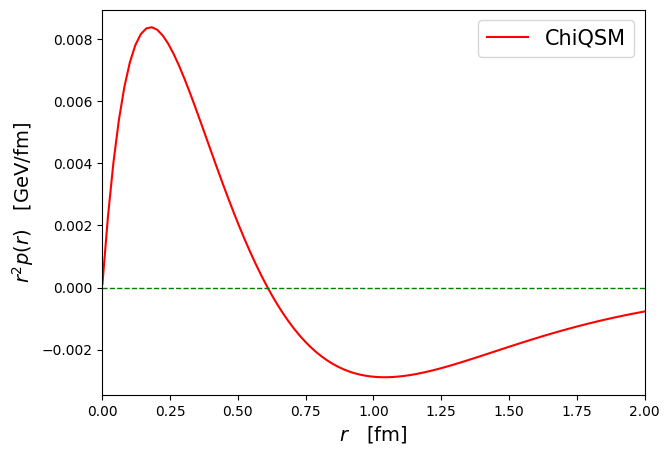

In [148]:
# Plotting the distribution for ChiQSM parameters from hep-ph/0702030
# d_1(0) = -2.35, M = 0.646,  so D(0) = 1.88
fig, ax = plt.subplots(1, 1, figsize=[7,5])
rs = np.linspace(0.001,2,100)
ps = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=-1.88, M=0.646, p=2))
ax.plot(rs, ps, 'r-', label='ChiQSM')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
#fig.savefig('figs/pressure.pdf')

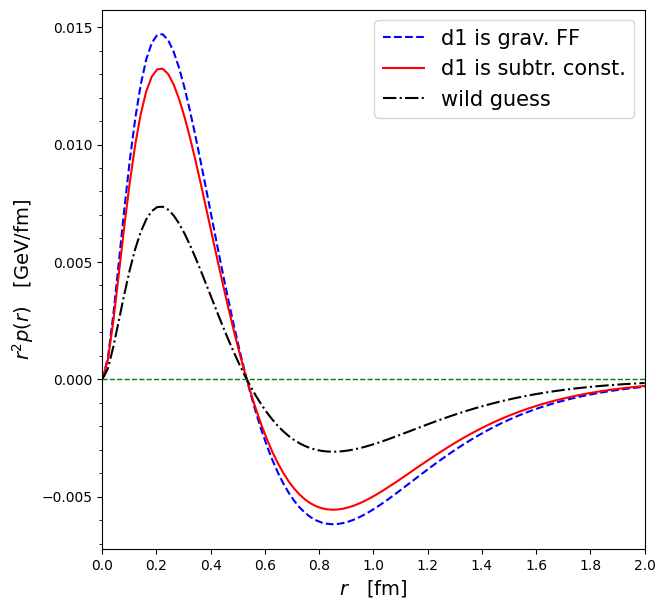

In [149]:
Mval = np.sqrt(1.06)
D0val = -2.04 * (4./5.) # d_1 is grav. form. fact.
D0valA = -2.04 * (18./25.)  # d_1 is subtr. const
D0valB = -2.04 * (18./25.)*(5./9.)  # wild guess
fig, ax = plt.subplots(1, 1, figsize=[7,7])
rs = np.linspace(0.001,2,100)
ps = []
psA = []
psB = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=D0val, M=Mval, p=2.76))   
    psA.append(pressure(r, Dterm, D0=D0valA, M=Mval, p=2.76))
    psB.append(pressure(r, Dterm, D0=D0valB, M=Mval, p=2.76))
ax.plot(rs, ps, 'b--', label='d1 is grav. FF')
ax.plot(rs, psA, 'r-', label='d1 is subtr. const.')
ax.plot(rs, psB, 'k-.', label='wild guess')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.001))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))

### Pressure distribution - uncertainties

In [150]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = np.sqrt(0.14**2 + 0.33**2) * (18./25.)*(5./9.)
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [151]:
# Sampling from Gaussian/normal distribution using scipy's stats routines
ss = 50 #  sample size
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [152]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

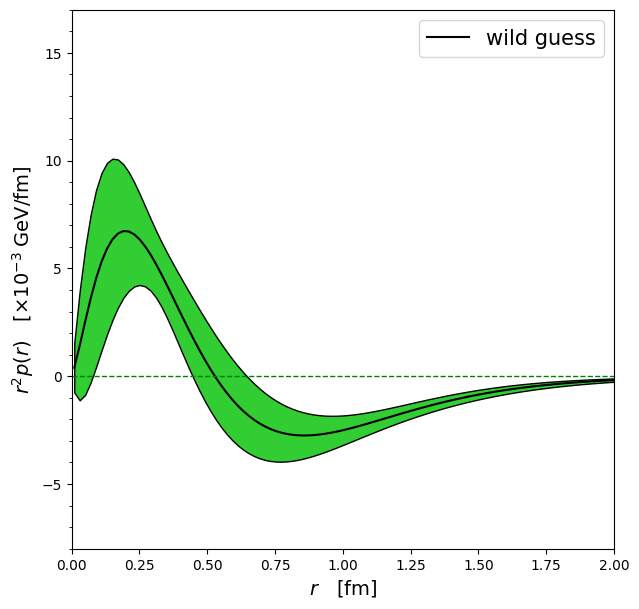

In [154]:
# I need to use "wild guess" option above to get agreement Fig. from Nature
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='limegreen',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
#fig.savefig('figs/pressure_nat.pdf')

In [155]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = 1.4 * (18./25.)  # as seen above, this is essentially t-independent
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [156]:
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [157]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

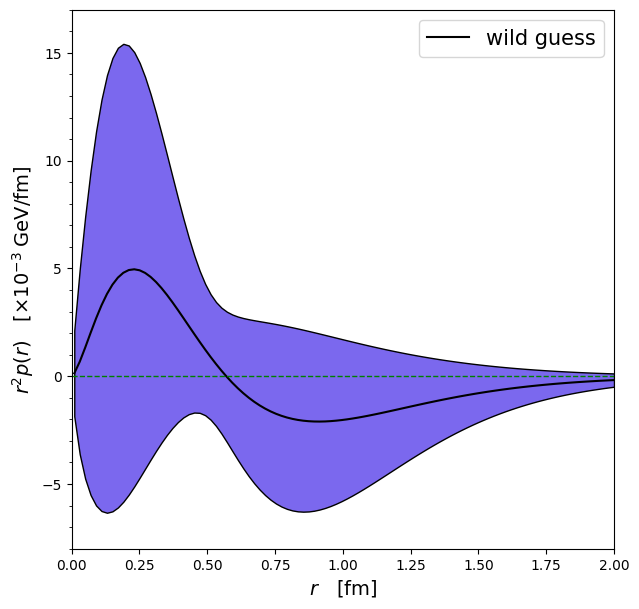

In [158]:
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='mediumslateblue',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
#fig.savefig('figs/pressure_NNet.pdf')

## Local fit of ImH and ReH to CLAS data

In [162]:
tNN = th2
tNN.m.output_layer 

['ImH', 'D']

In [155]:
binD = {}
binS = {}
binDS = {}

In [174]:
def tmin(xB, Q2):
    """BMK Eq. (31)"""

    eps2 = (4. * xB**2 * Mp2) / Q2
    return (-Q2 * ( 2. * (1.-xB)*(1. - np.sqrt(1.+eps2)) + eps2 ) / (
            4. * xB * (1.-xB) + eps2 ))

In [180]:
def makefit(tbin, nxis): 
    """ Perform simultaneous fit of both ImH and ReH."""
    for xbin in range(nxis):
        binD[(tbin,xbin)] = BSD.loc[(tmlims[tbin] < BSD.tm) & 
                                    (BSD.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSD.xi) & (BSD.xi < xilims[xbin+1])]
        binS[(tbin,xbin)] = BSS.loc[(tmlims[tbin] < BSS.tm) & 
                                    (BSS.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSS.xi) & (BSS.xi < xilims[xbin+1])]
        binDS[(tbin,xbin)] = pd.concat([binD[(tbin,xbin)], 
                                        binS[(tbin,xbin)]], ignore_index=True)
    totchi = 0
    ndof = 0
    sys.stdout.write('-- Bin: ')
    CFFs = ['pImH', 'pReH']
    CFFvals = []
    CFFerrs = []
    xis = []
    pts = []
    for xbin in range(nxis):
        # Model creation
        #m = model.ModelLocal()
        #m.parameters['pImH'] = 10.
        #th = Approach.BM10tw2(m)
        th.name = 'local-bin-%2s' % (xbin,)
        th.model.fix_parameters('ALL')
        th.model.release_parameters(*CFFs)
        # Fit to data in given bin
        sys.stdout.write('%2s .. ' % (xbin,))
        f = fitter.FitterMinuit(binDS[(tbin,xbin)].pt.values, th)
        xis.append(binDS[(tbin,xbin)].xi.mean())
        pts.append(binD[(tbin,xbin)].pt.values[0])
        #f.printMode = 2
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-len(CFFs)
        vals= []
        errs = []
        for p in CFFs:
                vals.append(th.m.parameters[p])
                errs.append(np.sqrt(th.m.covariance[p,p]))
        CFFvals.append(vals)
        CFFerrs.append(errs)

    CFFvals = np.array(CFFvals)
    CFFerrs = np.array(CFFerrs)

    print("\n chisq/ndof = {:.1f}/{}".format(totchi,ndof))
    return xis, pts, CFFvals, CFFerrs


In [181]:
def makefitstep(tbin, nxis):
    """ Perform step-wise fit, first ImH, then ReH ... not significant"""
    for xbin in range(nxis):
        binD[(tbin,xbin)] = BSD.loc[(tmlims[tbin] < BSD.tm) & 
                                    (BSD.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSD.xi) & (BSD.xi < xilims[xbin+1])]
        binS[(tbin,xbin)] = BSS.loc[(tmlims[tbin] < BSS.tm) & 
                                    (BSS.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSS.xi) & (BSS.xi < xilims[xbin+1])]
        binDS[(tbin,xbin)] = pd.concat([binD[(tbin,xbin)], 
                                        binS[(tbin,xbin)]], ignore_index=True)
    totchi = 0
    ndof = 0
    sys.stdout.write('-- Bin: ')
    CFFs = ['pImH', 'pReH']
    CFFvals = []
    CFFerrs = []
    xis = []
    pts = []
    for xbin in range(nxis):
        # Model creation
        #m = model.ModelLocal()
        #m.parameters['pImH'] = 10.
        #th = Approach.BM10tw2(m)
        #th.name = 'local-bin-%2s' % (xbin,)
        th.model.fix_parameters('ALL')
        sys.stdout.write('%2s .. ' % (xbin,))
        xis.append(binDS[(tbin,xbin)].xi.mean())
        pts.append(binD[(tbin,xbin)].pt.values[0])
        # Fit to BSD data in given bin
        th.model.release_parameters('pImH')
        f = fitter.FitterMinuit(binD[(tbin,xbin)].pt.values, th)
        #f.printMode = 2   
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-1
        valImH = th.m.parameters['pImH']
        errImH = np.sqrt(th.m.covariance['pImH','pImH'])
        # Now fit to BSS data
        th.model.fix_parameters('pImH')
        th.model.release_parameters('pReH')
        f = fitter.FitterMinuit(binS[(tbin,xbin)].pt.values, th)
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-1
        th.model.release_parameters('pImH')
        valReH = th.m.parameters['pReH']
        errReH = np.sqrt(th.m.covariance['pReH','pReH'])
        vals= [valImH, valReH]
        errs = [errImH, errReH]
        CFFvals.append(vals)
        CFFerrs.append(errs)

    CFFvals = np.array(CFFvals)
    CFFerrs = np.array(CFFerrs)

    print("\n chisq/ndof = {:.1f}/{}".format(totchi,ndof))
    return xis, pts, CFFvals, CFFerrs

In [182]:
def makefig():
    """Plot the results of the local fits together with NNet and KM fits"""
    xirange = np.linspace(0.05, 0.3, 20)
    CFFs = ['ImH', 'ReH']
    ex_pt = copy.deepcopy(pts[0])
    fig, axs = plt.subplots(1, 2, figsize=[12,6])
    for p in range(2):
        axs[p].errorbar(xis, CFFvals[:,p], CFFerrs[:,p], linestyle='None', marker='s', 
                       label='local fit')
        ys = []
        ys2 = []
        ysNN = []
        ysNNerr = []
        for xi in xirange:
            pt = ex_pt.copy()
            pt.xB = 2*xi/(1+xi)
            del pt.W
            del pt.xi
            del pt.tm
            #utils.fill_kinematics(pt)
            th15.m.g.newcall = 1
            y = getattr(th15.m, CFFs[p])(pt)
            th12.m.g.newcall = 1
            y2 = getattr(th12.m, CFFs[p])(pt)
            try:
                yall = getattr(tNN.m, CFFs[p])(pt)
                ysNN.append(yall.mean())
                ysNNerr.append(yall.std())
            except:
                print('some NN failure')
                pass    
            ys.append(y)
            ys2.append(y2)
        ysNN = np.array(ysNN)
        ysNNerr = np.array(ysNNerr)
        axs[p].fill_between(xirange, ysNN-ysNNerr, ysNN+ysNNerr, alpha=0.2,
                    label=tNN.name, color='green')#, zorder=0)
        axs[p].plot(xirange, ys, 'r-', label='KM15')
        axs[p].plot(xirange, ys2, 'k--', label='KMM12')
        axs[p].set_xlabel(r'$\xi$', fontsize=14)
        axs[p].set_xlim(0.03, 0.31)
    #axs[0].set_ylabel(r'Im(H)', fontsize=14)
    axs[0].set_ylabel(r'$\mathfrak{Im}\,\mathcal{H}$', fontsize=18)
    axs[0].set_ylim(0., 10.)
    axs[1].legend(loc="lower right", fontsize=15)
    axs[1].set_ylabel(r'Re(H)', fontsize=14)
    axs[1].set_ylabel(r'$\mathfrak{Re}\,\mathcal{H}$', fontsize=18)      
    axs[1].axhline(y=0, linewidth=0.8, linestyle=':', color='k')  # y=0 thin line
    axs[1].set_ylim(-10., 4.)
    axs[0].text(0.05, 1, r'$t = {}\,{{\rm GeV}}^2$'.format(pts[0].t), fontsize=15,
                bbox=dict(facecolor='gold', alpha=0.3))
    return fig


In [183]:
xis, pts, CFFvals, CFFerrs = makefit(0,3)

-- Bin: 

TypeError: 'NoneType' object is not callable

In [179]:
fig = makefig()

NameError: name 'pts' is not defined